In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
from datetime import datetime
import re

In [21]:
def create_legend(lrs, clrs):
    legend_elements = []
    for c, lr in zip(clrs,lrs):
        legend_elements.append(Line2D([0], [0], color=c, lw=4, label='lr=' + lr))

    legend_elements.append(Line2D([0], [0], dashes=(2,1), lw=4, label='training'))
    legend_elements.append(Line2D([0], [0], lw=4, label='validation'))

    return legend_elements

def plot_tr_vs_val(lrs, hists, clrs, tr_key, val_key, title, splot, save):
    plt.subplot(splot)
    for c, lr, hist in zip(clrs,lrs,hists):
        plt.plot(hist[tr_key], c +'--')
        plt.plot(hist[val_key], c+ '-')


    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(tr_key)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

def plot_training_multiple(name, title, save):

    run_folder = './saved_runs/'
    files = os.listdir(run_folder)

    age_hists = []
    gender_hists = []
    race_hists = []
    lrs = []
    lrre = re.compile('lr_\d+.\d+')
    
    
    for f in files:
        idx = f.find(name)
        if idx != -1:
            # lrs.append(lrre.search(f).group()[3:])
            hist = pd.read_csv(run_folder + f, index_col=0)
            hist = hist.to_dict('split')
            hist = dict(zip(hist['index'],hist['data']))
            age_idx = f.find(name + '_age')
            gender_idx = f.find(name + '_gender')
            race_idx = f.find(name + '_race')
            if age_idx != -1:
                lrs.append(lrre.search(f).group()[3:])
                age_hists.append(hist)
            elif gender_idx != -1:
                gender_hists.append(hist)
            elif race_idx != -1:
                race_hists.append(hist)

    plt.figure(figsize=(20,20))
    clrs = 'bgrcmykw'[0:len(lrs)]

    plot_tr_vs_val(lrs, age_hists, clrs, 'accuracy', 'val_accuracy', title + ' Age Accuracy', (231), save)
    plot_tr_vs_val(lrs, age_hists, clrs, 'loss', 'val_loss', title + ' Age Loss', (234), save)

    plot_tr_vs_val(lrs, gender_hists, clrs, 'accuracy', 'val_accuracy', title + ' Gender Accuracy', (232), save)
    plot_tr_vs_val(lrs, gender_hists, clrs, 'loss', 'val_loss', title + ' Gender Loss', (235), save)

    plot_tr_vs_val(lrs, race_hists, clrs, 'accuracy', 'val_accuracy', title + ' Race Accuracy', (233), save)
    plot_tr_vs_val(lrs, race_hists, clrs, 'loss', 'val_loss', title + ' Race Loss', (236), save)
    
    ax = plt.gca()
    ax.legend(handles=create_legend(lrs, clrs),bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if (save):
        plt.savefig('./saved_plots/' + title + ' ' + str(datetime.now().strftime("%m-%d-%Y %H:%M:%S")) + '.png')

    plt.show()

In [ ]:

lrre = re.compile('lr_\d+.\d+')
m = lrre.search('Task_1_age(lr_0.1)(batch_128)(epoch_100).csv')
print(m.group()[3:])

In [ ]:
def plot_training_single(file, title):

    hist = pd.read_csv(file, index_col=0)
    hist = hist.to_dict('split')
    hist = dict(zip(hist['index'],hist['data']))

    plt.plot(hist['accuracy'],label='training')
    plt.plot(hist['val_accuracy'], label='validation')
    plt.legend()
    plt.title(title + ' Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.savefig('./saved_plots/' + title + '_Accuracy_' + str(datetime.now()) + '.png')
    plt.show()

    plt.plot(hist['loss'],label='training')
    plt.plot(hist['val_loss'], label='validation')
    plt.legend()
    plt.title(title + ' Loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.savefig('./saved_plots/' + title + '_Loss_' + str(datetime.now()) + '.png')
    plt.show()

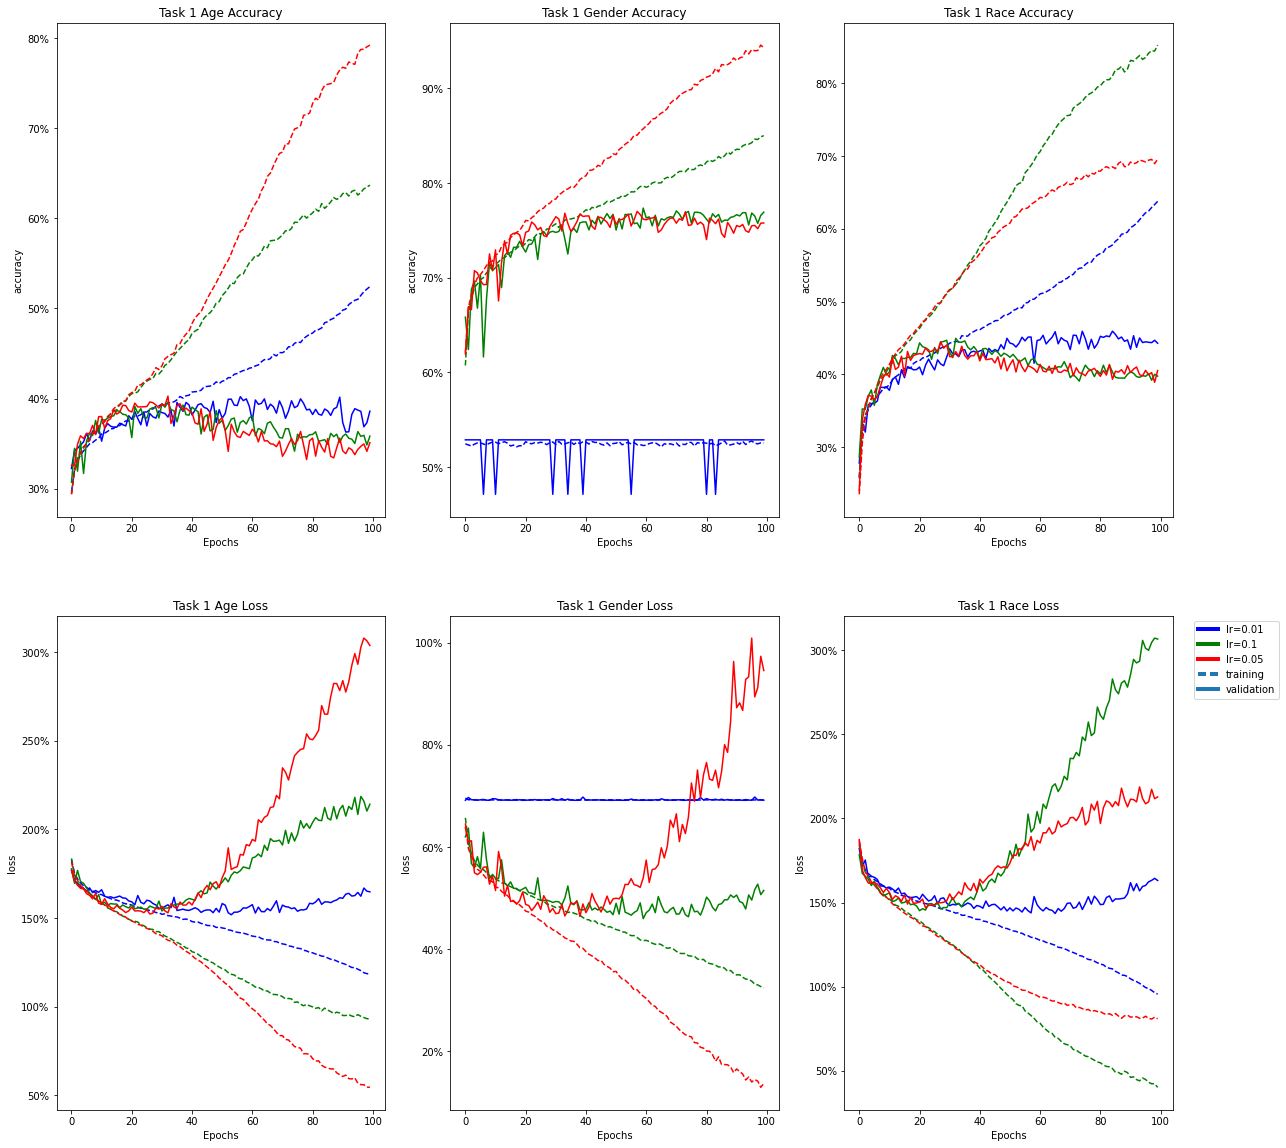

<Figure size 432x288 with 0 Axes>

In [15]:
plt = plot_training_multiple('Task_1', 'Task 1', True)

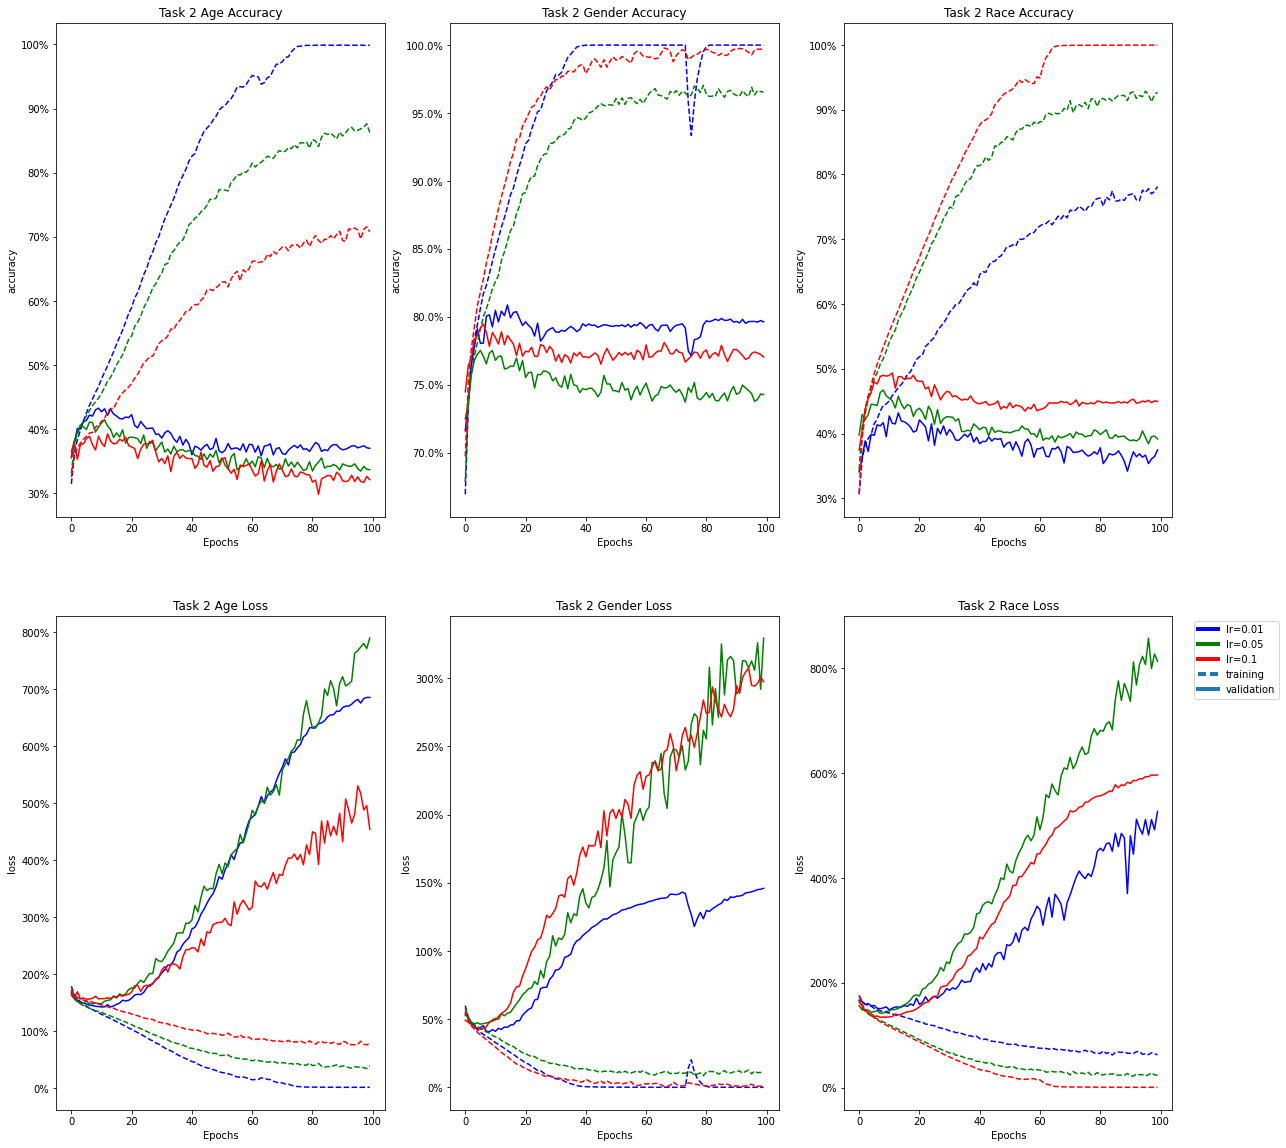

<Figure size 432x288 with 0 Axes>

In [19]:
plot_training_multiple('task_2', 'Task 2', True)

In [ ]:
plot_training_single('task_1_gender.csv', 'Task 1 Gender')

In [ ]:
plot_training_single('task_1_race.csv', 'Task 1 Race')

In [ ]:
plot_training_single('task_1_age.csv', 'Task 1 Age')

In [ ]:
plot_training_single('task_2_age.csv', 'Task 2 Age')

In [ ]:
plot_training_single('task_2_gender.csv', 'Task 2 Gender')

In [ ]:
plot_training_single('task_2_race.csv', 'Task 2 Race')